In [52]:
import matplotlib as mpl
from matplotlib import pyplot as plt
import torch
import torch.autograd as autograd
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time

In [1]:
import torch
import torchvision.datasets as datasets
import torchvision.transforms as transforms
train_dataset = datasets.MNIST(root='./data/',
                            train=True, 
                            transform=transforms.ToTensor(),
                            download=True)
test_dataset = datasets.MNIST(root='./data/',
                           train=False, 
                           transform=transforms.ToTensor())

Processing...
Done!


In [2]:
print(len(train_dataset))
print(len(test_dataset))
train_dataset[0][0]

60000
10000



(0 ,.,.) = 

Columns 0 to 8 
   0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000
  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000
  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000
  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000
  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000
  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000
  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.1176
  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.1922  0.9333
  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0706  0.8588
  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.3137
  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000
  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000
  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000
  0.0000  0.0000  0.

In [14]:
torch.manual_seed(3435)
train_img = torch.stack([d[0] for d in train_dataset])
train_label = torch.LongTensor([d[1] for d in train_dataset])
test_img = torch.stack([d[0] for d in test_dataset])
test_label = torch.LongTensor([d[1] for d in test_dataset])
print(train_img[0])
print(train_img.size(), train_label.size(), test_img.size(), test_label.size())


(0 ,.,.) = 

Columns 0 to 8 
   0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000
  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000
  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000
  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000
  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000
  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000
  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.1176
  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.1922  0.9333
  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0706  0.8588
  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.3137
  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000
  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000
  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000
  0.0000  0.0000  0.

In [15]:
val_img = train_img[-10000:].clone()
val_label = train_label[-10000:].clone()
train_img = train_img[:-10000]
train_label = train_label[:-10000]

In [16]:
train = torch.utils.data.TensorDataset(train_img, train_label)
val = torch.utils.data.TensorDataset(val_img, val_label)
test = torch.utils.data.TensorDataset(test_img, test_label)
BATCH_SIZE = 100
train_loader = torch.utils.data.DataLoader(train, batch_size=BATCH_SIZE, shuffle=True)
val_loader = torch.utils.data.DataLoader(val, batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(test, batch_size=BATCH_SIZE, shuffle=True)

In [92]:
#basic fully connected generator
class FC_Generator(nn.Module):
    
    def __init__(self, noise_dim, hidden_dim, output_dim):
        
        super(FC_Generator, self).__init__()
        
        self.noise_dim = noise_dim
        self.l1 = nn.Linear(noise_dim, hidden_dim)
        self.l2 = nn.Linear(hidden_dim, output_dim)
    
    #only take in number of needed initializations
    def forward(self, b_size):
        
        noise = torch.stack([torch.normal(torch.zeros(self.noise_dim), torch.ones(self.noise_dim)) for i in range(b_size)])
        noise = Variable(noise)
        f1 = self.l1(noise)
        f2 = F.relu(f1)
        f3 = self.l2(f2)
        f4 = F.sigmoid(f3)
        return f4
    

In [93]:
#basic fully connected 1 layer discriminator
class FC_Discriminator(nn.Module):
    
    def __init__(self, input_dim, hidden_dim, output_dim):
        
        super(FC_Discriminator, self).__init__()
        
        self.input_dim = input_dim
        self.l1 = nn.Linear(input_dim, hidden_dim)
        self.l2 = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, input_img):
        
        f1 = self.l1(input_img)
        f2 = F.relu(f1)
        f3 = self.l2(f2)
        f4 = F.sigmoid(f3)
        return f4
        

Epoch 0: Gen CE loss: 14.42 Disc CE loss 1.91 Time elapsed: 5.81
Generated Images Sample:


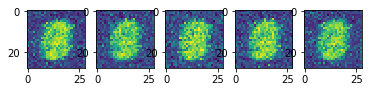

Epoch 10: Gen CE loss: 2.65 Disc CE loss 7.89 Time elapsed: 6.12
Generated Images Sample:


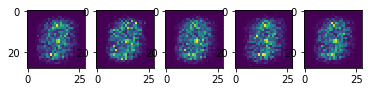

Epoch 20: Gen CE loss: 3.67 Disc CE loss 7.02 Time elapsed: 5.72
Generated Images Sample:


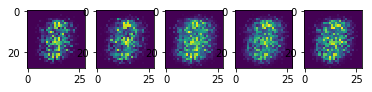

Epoch 30: Gen CE loss: 3.95 Disc CE loss 5.90 Time elapsed: 5.60
Generated Images Sample:


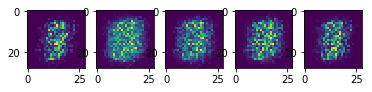

Epoch 40: Gen CE loss: 3.57 Disc CE loss 6.67 Time elapsed: 5.64
Generated Images Sample:


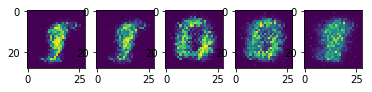

Epoch 50: Gen CE loss: 3.64 Disc CE loss 6.91 Time elapsed: 5.70
Generated Images Sample:


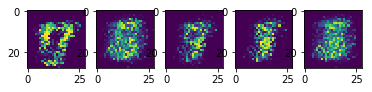

Epoch 60: Gen CE loss: 3.80 Disc CE loss 6.55 Time elapsed: 5.27
Generated Images Sample:


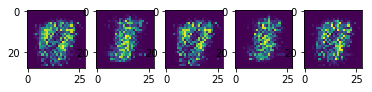

Epoch 70: Gen CE loss: 3.97 Disc CE loss 6.52 Time elapsed: 5.80
Generated Images Sample:


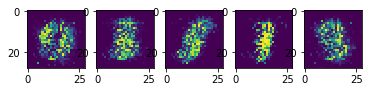

Epoch 80: Gen CE loss: 4.02 Disc CE loss 6.59 Time elapsed: 5.98
Generated Images Sample:


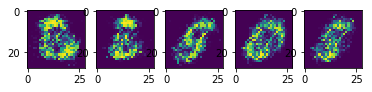

Epoch 90: Gen CE loss: 4.52 Disc CE loss 5.61 Time elapsed: 5.86
Generated Images Sample:


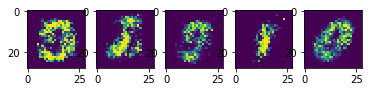

Epoch 100: Gen CE loss: 4.84 Disc CE loss 5.73 Time elapsed: 5.55
Generated Images Sample:


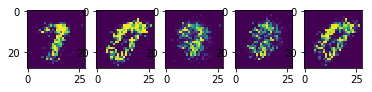

Epoch 110: Gen CE loss: 5.25 Disc CE loss 5.28 Time elapsed: 5.65
Generated Images Sample:


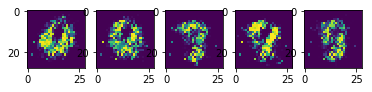

Epoch 120: Gen CE loss: 4.88 Disc CE loss 5.91 Time elapsed: 5.97
Generated Images Sample:


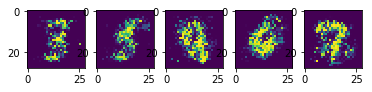

Epoch 130: Gen CE loss: 5.06 Disc CE loss 5.53 Time elapsed: 5.51
Generated Images Sample:


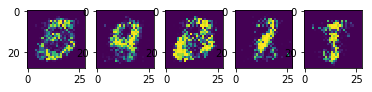

Epoch 140: Gen CE loss: 4.44 Disc CE loss 6.23 Time elapsed: 6.00
Generated Images Sample:


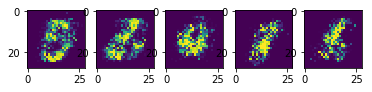

Epoch 150: Gen CE loss: 4.32 Disc CE loss 6.32 Time elapsed: 5.68
Generated Images Sample:


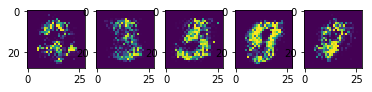

Epoch 160: Gen CE loss: 4.87 Disc CE loss 5.65 Time elapsed: 5.77
Generated Images Sample:


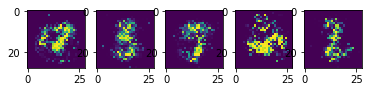

Epoch 170: Gen CE loss: 5.63 Disc CE loss 5.38 Time elapsed: 6.18
Generated Images Sample:


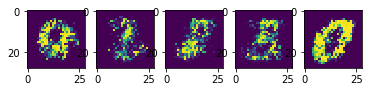

Epoch 180: Gen CE loss: 5.08 Disc CE loss 5.73 Time elapsed: 5.69
Generated Images Sample:


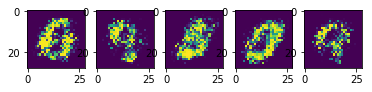

Epoch 190: Gen CE loss: 5.53 Disc CE loss 5.50 Time elapsed: 6.07
Generated Images Sample:


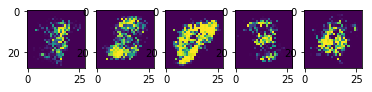

Epoch 200: Gen CE loss: 4.89 Disc CE loss 6.23 Time elapsed: 4.85
Generated Images Sample:


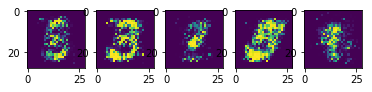

Epoch 210: Gen CE loss: 4.73 Disc CE loss 6.08 Time elapsed: 5.95
Generated Images Sample:


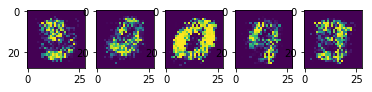

Epoch 220: Gen CE loss: 4.52 Disc CE loss 6.41 Time elapsed: 5.32
Generated Images Sample:


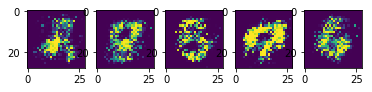

Epoch 230: Gen CE loss: 4.68 Disc CE loss 6.22 Time elapsed: 6.05
Generated Images Sample:


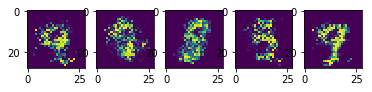

Epoch 240: Gen CE loss: 4.54 Disc CE loss 6.16 Time elapsed: 5.60
Generated Images Sample:


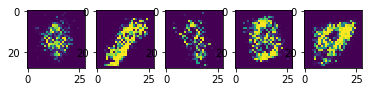

Epoch 250: Gen CE loss: 5.35 Disc CE loss 5.38 Time elapsed: 6.26
Generated Images Sample:


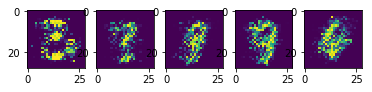

Epoch 260: Gen CE loss: 4.41 Disc CE loss 6.36 Time elapsed: 5.93
Generated Images Sample:


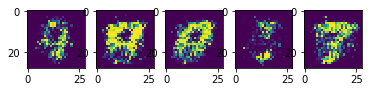

Epoch 270: Gen CE loss: 4.42 Disc CE loss 6.31 Time elapsed: 5.46
Generated Images Sample:


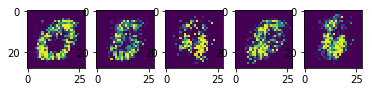

Epoch 280: Gen CE loss: 4.54 Disc CE loss 6.26 Time elapsed: 5.83
Generated Images Sample:


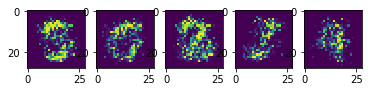

Epoch 290: Gen CE loss: 4.22 Disc CE loss 6.48 Time elapsed: 5.82
Generated Images Sample:


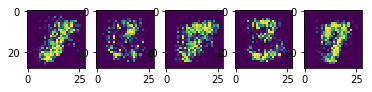

Epoch 300: Gen CE loss: 4.50 Disc CE loss 6.15 Time elapsed: 6.19
Generated Images Sample:


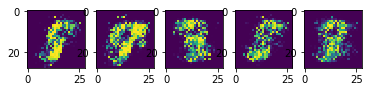

Epoch 310: Gen CE loss: 4.38 Disc CE loss 6.22 Time elapsed: 5.77
Generated Images Sample:


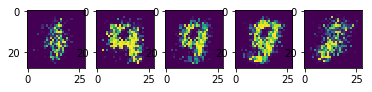

Epoch 320: Gen CE loss: 4.16 Disc CE loss 6.70 Time elapsed: 6.24
Generated Images Sample:


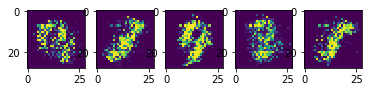

Epoch 330: Gen CE loss: 3.97 Disc CE loss 6.56 Time elapsed: 6.13
Generated Images Sample:


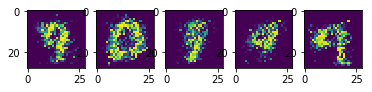

Epoch 340: Gen CE loss: 4.16 Disc CE loss 6.44 Time elapsed: 6.21
Generated Images Sample:


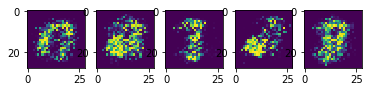

Epoch 350: Gen CE loss: 4.16 Disc CE loss 6.56 Time elapsed: 5.94
Generated Images Sample:


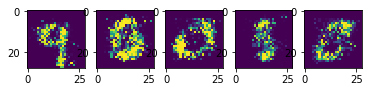

Epoch 360: Gen CE loss: 4.88 Disc CE loss 5.87 Time elapsed: 6.01
Generated Images Sample:


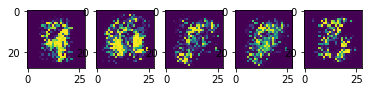

Epoch 370: Gen CE loss: 4.43 Disc CE loss 6.35 Time elapsed: 5.17
Generated Images Sample:


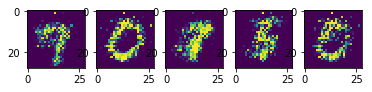

Epoch 380: Gen CE loss: 4.16 Disc CE loss 6.53 Time elapsed: 5.88
Generated Images Sample:


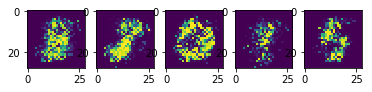

Epoch 390: Gen CE loss: 4.13 Disc CE loss 6.66 Time elapsed: 6.03
Generated Images Sample:


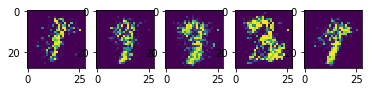

Epoch 400: Gen CE loss: 4.08 Disc CE loss 6.70 Time elapsed: 5.92
Generated Images Sample:


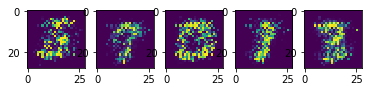

Epoch 410: Gen CE loss: 4.09 Disc CE loss 6.70 Time elapsed: 6.22
Generated Images Sample:


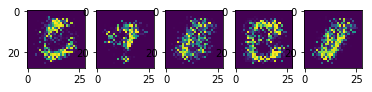

Epoch 420: Gen CE loss: 4.14 Disc CE loss 6.33 Time elapsed: 6.31
Generated Images Sample:


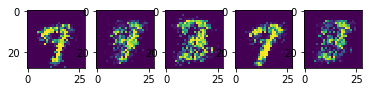

Epoch 430: Gen CE loss: 4.07 Disc CE loss 6.65 Time elapsed: 6.08
Generated Images Sample:


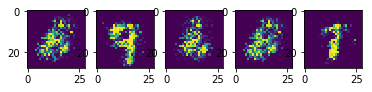

Epoch 440: Gen CE loss: 3.97 Disc CE loss 6.64 Time elapsed: 6.00
Generated Images Sample:


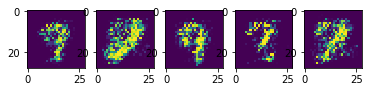

Epoch 450: Gen CE loss: 3.83 Disc CE loss 6.86 Time elapsed: 6.37
Generated Images Sample:


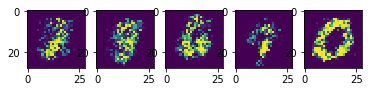

Epoch 460: Gen CE loss: 3.82 Disc CE loss 6.90 Time elapsed: 5.81
Generated Images Sample:


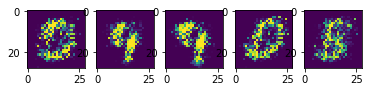

Epoch 470: Gen CE loss: 3.85 Disc CE loss 6.69 Time elapsed: 4.94
Generated Images Sample:


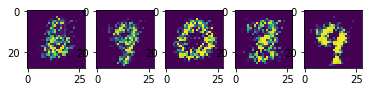

Epoch 480: Gen CE loss: 3.69 Disc CE loss 7.00 Time elapsed: 5.98
Generated Images Sample:


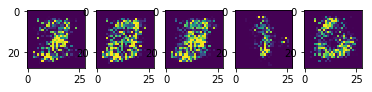

Epoch 490: Gen CE loss: 3.90 Disc CE loss 6.72 Time elapsed: 5.86
Generated Images Sample:


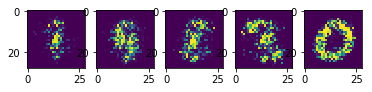

In [ ]:
saved_model = None
def train_GAN(models = None, epochs = 500, learning_rate = 0.0001):
    
    if not models:
        discr = FC_Discriminator(28*28, 20, 1)
        gen = FC_Generator(10, 40, 28*28)
        
        gen_optim = models[3]
        discr_optim = models[2]
        
    else:
        discr = models[0]
        gen = models[1]
        
        gen_optim = torch.optim.Adam(gen.parameters(),lr=learning_rate)
        discr_optim = torch.optim.Adam(discr.parameters(),lr=learning_rate)
    
    d_loss = nn.BCELoss()
    
    
    
    for epoch in range(epochs):
        
        batches = 0
        total_gen_loss = 0
        total_disc_loss = 0
        start_time = time.time()
        
        for img, _ in train_loader:
            
            #images
            x_real = Variable(img.view(train_loader.batch_size, -1))
            x_fake = gen(train_loader.batch_size)
            
            #labels
            y_real = Variable(torch.ones(train_loader.batch_size))
            y_fake = Variable(torch.zeros(train_loader.batch_size))
            
            y_hat_real = discr(x_real)
            y_hat_fake = discr(x_fake)
            real_loss = d_loss(y_hat_real.squeeze(),y_real)
            fake_loss = d_loss(y_hat_fake.squeeze(),y_fake)
            
            #step for discriminator
            disc_loss = real_loss + fake_loss
            total_disc_loss += disc_loss
            discr.zero_grad()
            disc_loss.backward(retain_graph=True)
            discr_optim.step()
            
            #step for generator
            gen_loss = d_loss(y_hat_fake.squeeze(), y_real)
            total_gen_loss += gen_loss
            discr.zero_grad()
            gen.zero_grad()
            gen_loss.backward()
            gen_optim.step()
        
        if epoch % 10 == 0:
            delta = time.time()-start_time
            total_gen_loss /= float(train_loader.batch_size)
            total_disc_loss /= float(train_loader.batch_size)

            print("Epoch %d: Gen CE loss: %.2f Disc CE loss %.2f Time elapsed: %.2f" % (epoch, total_gen_loss, total_disc_loss, delta))
            print("Generated Images Sample:")

            #generate and print 5 sample images
            z_ = gen(5)
            plt.figure()
            for i, image in enumerate(z_.data):
                plt.subplot(1,5,i+1)
                plt.imshow(image.view(28,28),cmap='gray')
            plt.show()
            
            
            
        saved_model = (discr, gen, discr_optim, gen_optim)
        
    return (discr, gen, discr_optim, gen_optim)
            
            
my_model = train_GAN()            

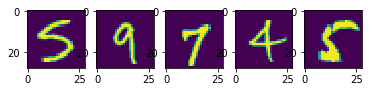

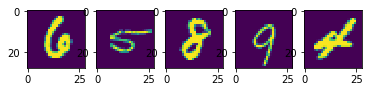

In [84]:
a,_=next(iter(train_loader))
plt.figure()
for i, image in enumerate(a[:5]):
    #print(image)
    plt.subplot(1,5,i+1)
    plt.imshow(image.view(28,28))
    
plt.figure()
for i, image in enumerate(a[5:10]):
    #print(image)
    plt.subplot(1,5,i+1)
    plt.imshow(image.view(28,28))

In [18]:
torch.cuda.is_available()

True

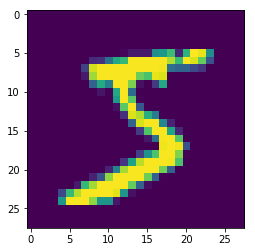

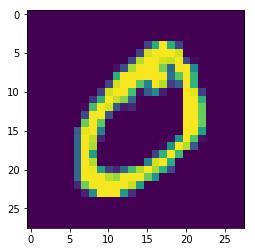

In [38]:
plt.figure()
plt.imshow(train_img[0].squeeze())

plt.figure()
plt.imshow(train_img[1].squeeze())

In [42]:
a,_=next(iter(train_loader))

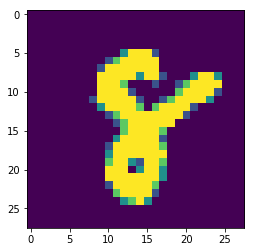

In [44]:
plt.imshow(a.view(train_loader.batch_size, -1)[0].view(28,28))